In [1]:
import os
import cv2
import random
import numpy as np
import shutil
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

c:\Users\danim\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def leer_anotaciones_yolo(anotacion_txt):
    with open(anotacion_txt, "r") as f:
        lineas = f.readlines()
    
    anotaciones = []
    for linea in lineas:
        anotaciones.append([float(i) for i in linea.strip().split(" ")])
        
    return anotaciones

In [3]:
def guardar_anotaciones_yolo(anotaciones, archivo_salida):
    with open(archivo_salida, "w") as f:
        for anotacion in anotaciones:
            linea = " ".join(str(i) for i in anotacion)
            f.write(linea + "\n")

In [4]:
def aplicar_transformacion(img, anotaciones, transform):
    labels = [x[0] for x in anotaciones]
    bboxes = [x[1:] for x in anotaciones]
    
    resultado = transform(image=img, bboxes=bboxes, labels=labels)
    img_transformada = resultado["image"]
    anotaciones_transformadas = [
        [label, *box] for label, box in zip(resultado['labels'], resultado['bboxes']) if box[2] > 0 and box[3] > 0
    ]
    
    return img_transformada, anotaciones_transformadas


In [28]:
def aumentar_dataset(input_folder, output_folder, num_output_images=300):
    transform = A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0.3, 0.5), p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10, 50), mean=0, p=0.5),
        A.GaussianBlur(p=0.5),
        A.MotionBlur(p=0.5),
        A.CLAHE(clip_limit=4.0, p=0.5),
        A.Cutout(num_holes=8, max_h_size=16, max_w_size=16, p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_area=0.001, min_visibility=0.001))


    transform_original = A.Compose([
        A.Resize(800, 800)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_area=0.001, min_visibility=0.001))


    os.makedirs(output_folder, exist_ok=True)

    images_path = os.path.join(input_folder, "images")
    labels_path = os.path.join(input_folder, "labels")

    all_files = os.listdir(images_path)
    img_files = [f for f in all_files if f.endswith(".jpg")]
    num_files = len(img_files)

    for img_name in img_files:
        img_path = os.path.join(images_path, img_name)
        txt_path = os.path.join(labels_path, f"{img_name[:-4]}.txt")

        # Verifica si existe el archivo .txt antes de continuar
        if not os.path.exists(txt_path):
            continue
        
        img = cv2.imread(img_path)
        anotaciones = leer_anotaciones_yolo(txt_path)

        # Aplica la transformación de redimensionamiento a la imagen original y sus anotaciones
        img_resized, anotaciones_resized = aplicar_transformacion(img, anotaciones, transform_original)

        # Guarda la imagen original redimensionada y su archivo de anotaciones en el directorio de salida
        cv2.imwrite(os.path.join(output_folder, img_name), img_resized)
        guardar_anotaciones_yolo(anotaciones_resized, os.path.join(output_folder, f"{img_name[:-4]}.txt"))
       
        # Bucle para generar imágenes aumentadas y guardarlas en el directorio de salida
        for i in range(num_output_images // num_files):
            img_aug, anotaciones_aug = aplicar_transformacion(img, anotaciones, transform)

            new_img_name = f"{img_name[:-4]}_aug_{i}.jpg"
            new_txt_name = f"{img_name[:-4]}_aug_{i}.txt"

            output_image_path = os.path.join(output_folder, "images")
            output_label_path = os.path.join(output_folder, "labels")
            os.makedirs(output_image_path, exist_ok=True)
            os.makedirs(output_label_path, exist_ok=True)

            cv2.imwrite(os.path.join(output_image_path, new_img_name), img_aug)
            guardar_anotaciones_yolo(anotaciones_aug, os.path.join(output_label_path, new_txt_name))

In [31]:

input_folder = r"C:\Users\danim\Documents\yolov8_grapes\dataset_qr\train"
output_folder = r"C:\Users\danim\Documents\yolov8_grapes\dataset_qr\train_aug"
num_output_images = 200

aumentar_dataset(input_folder, output_folder, num_output_images)

In [34]:
import cv2
import os
import albumentations as A

def mejorar_brillo_contraste(input_image_path, output_image_path):
    # Define la transformación para ajustar el brillo y el contraste de la imagen
    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0.3, 0.5), p=1.0),
        A.HueSaturationValue(sat_shift_limit=40, p=1.0),  # Aumenta la diferencia de color
        A.ImageCompression(quality_lower=60, quality_upper=100, p=1.0),  # Mejora los detalles de la imagen

    ])

    # Lee la imagen de entrada
    img = cv2.imread(input_image_path)

    # Aplica la transformación de brillo y contraste a la imagen
    img_transformed = transform(image=img)["image"]

    # Guarda la imagen mejorada en el directorio de salida
    cv2.imwrite(output_image_path, img_transformed)


In [35]:

# Ejemplo de uso de la función:
input_folder = "/Users/baudi/AI/practicas/grapes/test"
output_folder = "/Users/baudi/AI/practicas/grapes/test_improved"
os.makedirs(output_folder, exist_ok=True)

all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.endswith(".jpg")]

for img_name in img_files:
    input_image_path = os.path.join(input_folder, img_name)
    output_image_path = os.path.join(output_folder, img_name)
    mejorar_brillo_contraste(input_image_path, output_image_path)


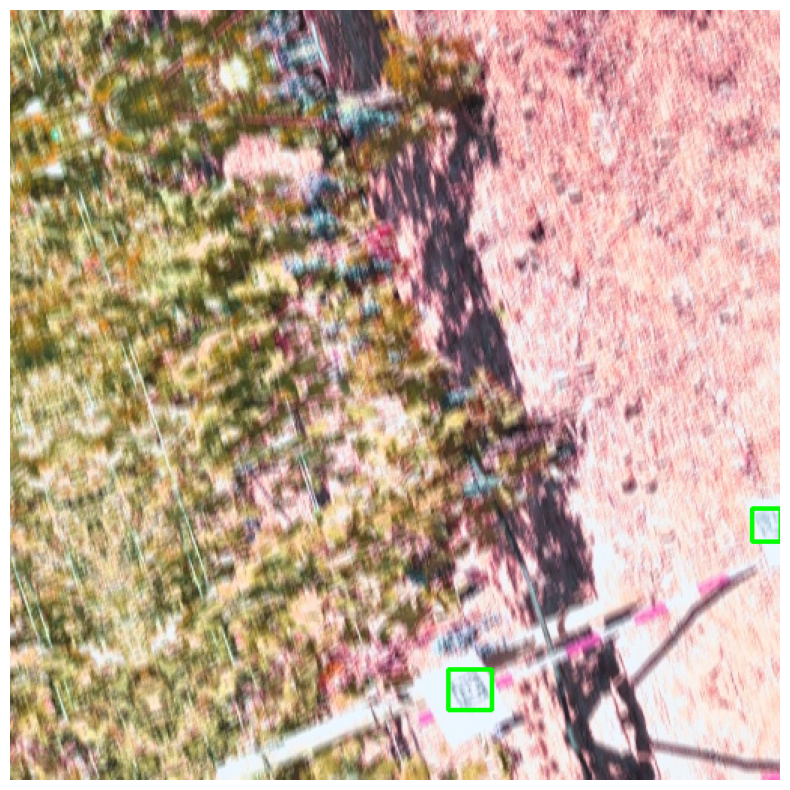

: 

In [48]:
import matplotlib.pyplot as plt

processed_images_path = output_folder + "/images"
processed_labels_path = output_folder + "/labels"

all_files = os.listdir(processed_images_path)

img_files = [f for f in all_files if f.endswith(".jpg")]

# Selecciona una imagen al azar

img_name = random.choice(img_files)

img_path = os.path.join(processed_images_path, img_name)
txt_path = os.path.join(processed_labels_path, f"{img_name[:-4]}.txt")

# Mostrar la imagen con sus bounding boxes
img = cv2.imread(img_path)
anotaciones = leer_anotaciones_yolo(txt_path)

for anotacion in anotaciones:
    x, y, w, h = anotacion[1:]
    x = x * img.shape[1]
    y = y * img.shape[0]
    w = w * img.shape[1]
    h = h * img.shape[0]
    
    cv2.rectangle(img, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), (0, 255, 0), 2)

# Muestra la imagen con sus bounding boxes usando matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img[:, :, ::-1])
plt.axis("off")
plt.show()